# Tutorial - FRET assisted modeling Pipeline (FAMP)

Welcome to the FAMP tutorial. This notebook demonstrates the use of individual functions within the FAMP pipeline. In this tutorial, a simple RNA hairpin will be modeled, simulated, and FRET predicted using the Modeling, Simulation, and Data Analysis modules.

Note: Descriptions of parameters and the general process for FRET-assisted modeling are available in the documentation for this program.

The sequence of the Hairpin:
```
>RNA_Hairpin sequence
caauauuuauuaauaucuuccggauauuaauaaauauug
```

In [11]:
import os
import famp
import pathlib
print(pathlib.Path(os.path.dirname(os.path.realpath(famp.__file__))).parent())

TypeError: 'PosixPath' object is not callable

## Part 1: *de novo* modeling

Modeling capabilities within the pipeline program are restricted to de novo modeling, utilizing two external programs. Secondary structure prediction is performed using the RNA Fold program, while Rosetta is employed for tertiary structure prediction.

All functionalities are encapsulated within the Modeling class. The class is instantiated by making a class call and specifying the following attributes:

- `working_dir` = directory in which the results are to be saved
- `file_path_sequence` = path to the input fasta sequence
- `modeling_parameter` = Python dictiononary with the defined modeling parameters (see parameters)

In [2]:
rosetta_parameter = {
    "path_to_rosetta": "rna_denovo.default.macosclangrelease",
    "nstruct": 5,
    "minimize_rna": True,
    "cycles": 1000,
    "overwrite": True,
}

current_dir = os.getcwd()
modeling_hairpin = famp.modeling.Modeling(working_dir=f"{current_dir}",
                    file_path_sequence=f"{current_dir}/input_data/RNA_Hairpin.fasta",
                    modeling_parameter=rosetta_parameter)

Read in Sequence: >RNA_Hairpin sequence


In [24]:
modeling_hairpin.run_command(f"extract_pdb.sh")

### Secondary structure prediction 
The secondary structure prediction is carried out using RNAFold. The results are stored in the *secondary_prediction* folder. The results are stored in dot-bracket format within the *dot_bracked.sectstruct* file. Since RNAFold was not designed to predict pseudoknots, these can be included in the file if necessary.
The dot-bracket format: The round brackets "()" stand for standart Watson and Crick base parings in the secondary Structure. Not paired bases are represented by dots ".". Pseudoknots can be represented as square brackets "[]".

In [4]:
modeling_hairpin.predict_2d_structure()

Results can be found in: /Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/secondary_prediction
2 caauauuuauuaauaucuuccggauauuaauaaauauug

1 ((((((((((((((((((...)))))))))))))))))) (-15.90)


### Tertiary structure prediction

In [9]:
modeling_hairpin.predict_3d_structure(f"{os.getcwd()}/secondary_prediction/dot_bracket.secstruct")

Results can be found in: /Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/rosetta_results


Basic usage:  rna_denovo.default.macosclangrelease  -fasta <fasta file with sequence>  [ -native <native pdb file> ] 



 Type -help for full slate of options.


core.init: Checking for fconfig files in pwd and ./rosetta/flags 

core.init: Rosetta version: rosetta.binary.mac.release-280 r280 2021.16+release.8ee4f02ac57 8ee4f02ac5768a8a339ffada74cb0ff5f778b3e6 https://www.rosettacommons.org 2021-04-20T11:45:16.822269

core.init: command: rna_denovo.default.macosclangrelease -nstruct 5 -sequence caauauuuauuaauaucuuccggauauuaauaaauauug -secstruct ((((((((((((((((((...)))))))))))))))))) -silent /Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/rosetta_results/silent_out.out -minimize_rna True -cycles 1000 -overwrite

basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-1616608936 seed_offset=0 real_seed=-1616608936

basi

In [3]:
modeling_hairpin.extract_pdb(5)

S_000004: -62.199

S_000002: -57.286

S_000005: -57.217

S_000001: -54.509

S_000003: -53.879


core.init: Checking for fconfig files in pwd and ./rosetta/flags 

core.init: Rosetta version: rosetta.binary.mac.release-280 r280 2021.16+release.8ee4f02ac57 8ee4f02ac5768a8a339ffada74cb0ff5f778b3e6 https://www.rosettacommons.org 2021-04-20T11:45:16.822269

core.init: command: extract_pdbs.default.macosclangrelease -in:file:silent /Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/rosetta_results/silent_out.out -tags S_000004 S_000002 S_000005 S_000001 S_000003

basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1263102996 seed_offset=0 real_seed=1263102996

basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1263102996 RG_type=mt19937

core.init: Resolved executable path: /Users/felixerichson/Documents/Rosetta/rosetta_bin_mac_2021.16.61629_bundle/main/source/bin/extract_pdbs.default.macosclangrelease

core.ini

In [11]:
print(modeling_hairpin.working_dir)

/Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial


In [8]:
famp.predict_2D_structure("RNA_Hairpin.fasta")

Successfully created the directory /Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development/sds_prediction. Results can be found there
2 caauauuuauuaauaucuuccggauauuaauaaauauug

1 ((((((((((((((((((...)))))))))))))))))) (-15.90)


# Tertiary Structure Modeling with Rosetta
With the programm rosetta it ist possible to gain a teriary structure model. As input we have a RNA sequence and the secondary structure from RNAfold

In [9]:
rosetta_parameter = {
    "path_to_rosetta": "rna_denovo.default.macosclangrelease",
    "nstruct" : 3,
    "fasta": "RNA_Hairpin.fasta",
    "minimize_rna": True,
    "cycles": 200
}

famp.predict_3D_structure("sds_prediction/dot_bracket.secstruct", rosetta_parameter)
famp.extract_pdb(1)
#subprocess.run(["pymol","./rosetta_results/out/1/silent_out.pdb"])

Successfully created the directory /Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development/rosetta_results. Results can be found there
CompletedProcess(args=['bash', '-c', './scripts/mac_os/rosetta/submitJobs.sh -i rosetta_results/FARFAR2.txt -d rosetta_results -p 1'], returncode=0, stdout="the specified output folder already exists\ndirectories for 1 processes created in ./rosetta_results/out.\nrna_denovo.default.macosclangrelease -nstruct 3 -sequence 'caauauuuauuaauaucuuccggauauuaauaaauauug'  -secstruct '((((((((((((((((((...))))))))))))))))))' -silent silent_out.out -minimize_rna True -cycles 200job 1 started...\n\nBasic usage:  rna_denovo.default.macosclangrelease  -fasta <fasta file with sequence>  [ -native <native pdb file> ] \n\n Type -help for full slate of options.\n\ncore.init: Checking for fconfig files in pwd and ./rosetta/flags \ncore.init: Rosetta version: rosetta.binary.mac.release-280 r280 2021.16+release.8ee4f02ac57 8ee4f02ac5768a8a3

In [10]:
subprocess.run(["pymol","./rosetta_results/out/1/silent_out.pdb"])

 PyMOL(TM) 2.5.4 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected OpenGL version 2.1. Shaders available.
 Detected GLSL version 1.20.
 OpenGL graphics engine:
  GL_VENDOR:   Apple
  GL_RENDERER: Apple M1
  GL_VERSION:  2.1 Metal - 83
 License Expiry date: 01-may-2023
 Detected 8 CPU cores.  Enabled multithreaded rendering.
TITLE S_000001
HEADER                                            09-NOV-22   XXXX
 CmdLoad: "" loaded as "silent_out".
 Setting: seq_view set to on.


2022-11-09 15:39:17.148 python[58227:5143524] +[CATransaction synchronize] called within transaction
2022-11-09 15:39:17.291 python[58227:5143524] +[CATransaction synchronize] called within transaction
2022-11-09 15:40:49.879 python[58227:5143524] +[CATransaction synchronize] called within transaction
2022-11-09 15:40:49.931 python[58227:5143524] +[CATransaction synchronize] called within transaction


CompletedProcess(args=['pymol', './rosetta_results/out/1/silent_out.pdb'], returncode=0)

# Define label positions


# Calculation of ACV with the FRETraj GUI

In [7]:
subprocess.run(["pymol"])

 PyMOL(TM) 2.4.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 License Expiry date: 01-may-2023
 Detected OpenGL version 4.6. Shaders available.
 Detected GLSL version 4.60.
 OpenGL graphics engine:
  GL_VENDOR:   NVIDIA Corporation
  GL_RENDERER: NVIDIA GeForce RTX 3070/PCIe/SSE2
  GL_VERSION:  4.6.0 NVIDIA 470.141.03
 Detected 24 CPU cores.  Enabled multithreaded rendering.


CompletedProcess(args=['pymol'], returncode=0)

# *in silico* labeleing: How to

In [10]:
subprocess.run(["pymol"])

 PyMOL(TM) 2.4.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 License Expiry date: 01-may-2023
 Detected OpenGL version 4.6. Shaders available.
 Detected GLSL version 4.60.
 OpenGL graphics engine:
  GL_VENDOR:   NVIDIA Corporation
  GL_RENDERER: NVIDIA GeForce RTX 3070/PCIe/SSE2
  GL_VERSION:  4.6.0 NVIDIA 470.141.03
 Detected 24 CPU cores.  Enabled multithreaded rendering.

 CmdLoad: "" loaded as "input".
 You clicked /input//A/RA`24/P
 Selector: selection "d_cy3" defined with 155 atoms.
 You clicked /input//A/RUM`10/C1' -> (pk1)
 You clicked /input//A/RUM`10/C1'
 You clicked /input//A/RUM`10/N1
 You clicked /input//A/RUM`10/N1
 Selector: selection "sele" defined with 57 atoms.
 You clicked /input//A/RUM`10/N1
 Selector: selection "sele" defined with 57 atoms.
 You clicked /input//A/RUM`10/C1'
 You clicked /input//A/RUM`10/C1'
 Scene: Origin set.
 Selector: selection "sele" defined with 57 atoms.
 You clicked 

CompletedProcess(args=['pymol'], returncode=0)

# MD Simulations with Gromacs:

In [5]:
os.chdir(working_dir_path)
simulation_parameter ={
    "input_structure": "input.pdb",
    "c_magnesium_ions[mol/l]":0.00,
    "simulation_time[ns]": 0.3,
    "temperature[°C]": 25,
    "dist_to_box[nm]": "1",
}
simulation_directory_name="MD_run_test"
famp.prepare_simulation(simulation_parameter, simulation_directory_name)
#copy_input_model("/cryo_em_model_labeled.pdb")
famp.copy_input_model("/rosetta_results/out/1/silent_out_labeled.pdb", simulation_directory_name)
#run_simulation_steps("input.pdb")

Successfully created the directory /Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development/MD_run_test. Results can be found there
ref_t                    = 298             ; reference temperature, one for each group, in K
gen_temp                 = 298                   ; temperature for Maxwell distribution
['; define                 = -DPOSRES              ; position restraints (commented = released)', 'integrator               = md                    ; leap-frog integrator', 'nsteps                   = 150000                ; number of steps to integrate', 'dt                       = 0.002                 ; integration timestep', 'nstxout                  = 0                     ; number of steps between writing coordinates to output trajectory (uncompressed, .trr)', 'nstvout                  = 0                     ; number of steps between writing velocities to output trajectory (uncompressed, .trr)', 'nstenergy                = 5000           

In [6]:
famp.solvate_molecule("input.pdb", simulation_parameter, simulation_directory_name, working_dir_path)

/Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development/MD_run_test
Successfully created the directory /Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development/MD_run_test/em. Results can be found there


                 :-) GROMACS - gmx pdb2gmx, 2021.2-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Tee

In [7]:
famp.run_simulation_steps("input.pdb", simulation_directory_name, working_dir_path)

/Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development/MD_run_test
Successfully created the directory /Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development/MD_run_test/nvt. Results can be found there


                 :-) GROMACS - gmx grompp, 2021.2-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

KeyboardInterrupt: 

# MD Postprocessing:

The remaining folders are created directly in the following with the next command. And the xtc file of the simulation is reduced to the atoms of the RNA

In [15]:
# Return to working directory
#os.chdir(working_dir_path)
#analysis_dir = make_data_analyis_results_dirs("MD_results_hairpin")
analysis_dir = f"felix/Documents/TLR_Mirko/md_tlr_longrun/analysis"
print(analysis_dir)

felix/Documents/TLR_Mirko/md_tlr_longrun/analysis


In [7]:
famp.remove_dyes_from_trajectory("MD_results_KLTL")

                 :-) GROMACS - gmx trjconv, 2021.2-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Tee

In [ ]:
famp.remove_dyes_from_trajectory(analysis_dir)

# Creating r_kappa files from MACV calculations

Die multiple ACV lassen sich nur berechnen wenn keine Farbstoffe am Biomolekül vorhanden sind. Auch bei simulationen welche Farbstoffe enthalten lohnt es sich das MACV mit den expliziten Farbstoffepositionen zu vergleichen. Daher werden im nächsten Schritt die Farbstoffe aus der Simulation entfernt.

Im ersten Schritt soll eine Indexdatei entstehen in der nur Atomnummern zu finden sind die zur RNA gehören. Dafür gibt es die Funktion `make_ndx_of_rna_without_dyes`. Die Funktion geht selbstständig durch die .gro Datei und schreibt eine .ndx Datei die nur Atome enthält die RNA related ist. Hier kann es noch zu fehlerchen kommen, da die Atome welche als RNA bezogen zählen selbst erstellt und in Dictionarys in der Funktion definiert werden.

Die `trjconv` Befehle erzeugen im Anschluss die Dateien die von `mdtraj`verwendet werden.

### Definitionen

Hier werden für die Visualisierung und Datenansteuerung ein paar Grundlegende Sachen definiert. Dabei wird nur der `ariables_dict` angepasst umd Dateinamen für Abbildungen zu defineiren.

## MACV Bestimmung

Bei der MACV Bestimmung werden für eine diskrete Anzahl an States einer MD Trajektorie die ACV besrechnet. Aus den sich daraus ergebenden Abstandstrajektorie können dann FRET Experimente simuliert werden.

Laden der MD Trajektorie ohne Farbstoffe

Ausgeben der Zeitschritte und der Atom Id's für die Bestimmung der Attechmentpoints. Mit den Id's der Attechmentpoints kann im Anschluss das Parameterfile für die Farbstoffe definiert werden.

In [9]:
print(analysis_dir)
traj = md.load(f'{analysis_dir}/raw/input_unlabeled.xtc', top=f'{analysis_dir}/raw/input_unlabeled_s1.pdb')
traj_df = traj.top.to_dataframe()[0]
traj_df.loc[((traj_df['resSeq']==10) & (traj_df['name']=='C5')) | ((traj_df['resSeq']==65) & (traj_df['name']=="O3'"))]
#print(len(traj))

/home/felix/PycharmProjects/FAMP_rna/FAM_Pipeline/MD_results_KLTL/analysis


OSError: No such file: /home/felix/PycharmProjects/FAMP_rna/FAM_Pipeline/MD_results_KLTL/analysis/raw/input_unlabeled_s1.pdb

### Dye Parameter for MACV calculations

In [10]:
labels = {"Position":
              {"Cy5-10-C5":
                   {"attach_id": 310,
                    "linker_length": 21,
                    "linker_width": 3.5,
                    "dye_radius1": 9.5,
                    "dye_radius2": 3,
                    "dye_radius3": 1.5,
                    "cv_fraction": 0.25,
                    "cv_thickness": 3,
                    "use_LabelLib": False},
               "Cy3-65-O3'":
                   {"attach_id": 2052,
                    "linker_length": 20.5,
                    "linker_width": 3.5,
                    "dye_radius1": 8,
                    "dye_radius2": 3,
                    "dye_radius3": 1.5,
                    "cv_fraction": 0.25,
                    "cv_thickness": 3,
                    "use_LabelLib": False},
               },
          "Distance": {"Cy3-Cy5":
                           {"R0": 54}
                       }
          }
ft.cloud.check_labels(labels, verbose=False)

### Calculation of MACV's
If `calc_macv = False`, then an existing MACV trajectory will load in . If True, the MACV along the MD trajectory are calculated.

In [11]:
famp.make_result_dir(f"MD_results_KLTL/analysis/macv")
macv_dir = f"{analysis_dir}/macv"
calc_macv = False
selected_frames = range(0,100001,1000)
if calc_macv:
    fret = ft.cloud.pipeline_frames(traj, "Cy3-65-O3'", 'Cy5-10-C5', labels, selected_frames, 'Cy3-Cy5')
    ft.cloud.save_obj(f'{macv_dir}/FRET_BTL_CryoEM_Dist_rest.pkl', fret)
else:
    fret = ft.cloud.load_obj(f'{macv_dir}/FRET_BTL_CryoEM_Dist_rest.pkl')

Failed to create /Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development//Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development/MD_results_KLTL_analysis/macv


### Creating the r_kappa.dat file from the MACV trajectory

In [12]:
fret_traj = ft.cloud.Trajectory(fret, timestep=traj.timestep, kappasquare=0.66)
fret_traj.save_traj(f'{analysis_dir}/macv/R_kappa_ACV.dat', format='txt', R_kappa_only=True, units='nm', header=False)
fret_traj.dataframe.head()

,<R_DA> (A),<E_DA>,<R_DA_E> (A),R_attach (A),R_mp (A),time (ps),kappasquare
0,45.1,0.70,46.8,40.5,41.8,0.0,0.66
1,42.9,0.75,45.2,40.4,39.1,10.0,0.66
2,47.7,0.65,48.8,43.8,44.3,20.0,0.66
3,46.9,0.67,48.2,42.7,43.5,30.0,0.66
4,45.2,0.70,46.9,40.2,41.7,40.0,0.66


# Creating r_kappa files from explicit dye simulations

In [13]:
famp.make_result_dir(f"MD_results_KLTL/analysis/fluorburst")

Failed to create /Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development//Users/felixerichson/Documents/Simulationen/Simulations_KLTL_complete/Pipeline_development/MD_results_KLTL_analysis/fluorburst


In [14]:
filter_par = [["10","C14"],["10","C2"],["10","C32"],["65","C14"],["65","C2"],["65","C11"]]
famp.get_atom_ids(f"{analysis_dir}/raw/input.gro", filter_par)

,Num/Res,Atom name,ID
0,10C5W,C14,311
1,10RUM,C14,341
2,10C5W,C2,334
3,10RUM,C2,359
4,10C5W,C32,304
5,65C3W,C14,2132
6,65C3W,C2,2155
7,65C3W,C11,2126


In [15]:
#Create a gro file consistent to the atoms availeble in the xtc file
famp.reduce_gro_file(f"{analysis_dir}/raw/input.gro",f"{analysis_dir}/Index_Files/RNA.ndx")
# Load the trajectory with MD Anlysis
u = mda.Universe(f"{analysis_dir}/raw/input_reduced.gro", f"{analysis_dir}/raw/input_centered.xtc")
# get the coordinates of donor and acceptor dipoles
donor = [famp.get_atoms_coordinates("2132", u), famp.get_atoms_coordinates("2155", u)]
acceptor = [famp.get_atoms_coordinates("311", u), famp.get_atoms_coordinates("334", u)]
# get the coordinated of mean donor and acceptor atoms
mean_don_acc = [famp.get_atoms_coordinates("2126", u), famp.get_atoms_coordinates("304", u)]

In [16]:
r_kappa_df = famp.get_rkappa_file_from_dyes(f"{analysis_dir}",donor, acceptor, mean_don_acc)
famp.write_coordinate_file(f"{analysis_dir}/fluorburst/Cy3.txt", donor)
famp.write_coordinate_file(f"{analysis_dir}/fluorburst/Cy5.txt", acceptor)

10001
10001
10001


# Burst Berechnung

## Parameter zur Burstberechung

Das folgende dictionary Zeigt die Parameter, welche zur Burstberechnung benötigt werden. Diese können auch in einer JSON Datei hitnerlegt und geladen werden.

In [17]:
parameters = {
    "dyes": {
        "tauD": 1,
        "tauA": 1,
        "QD": 1,
        "QA": 1,
        "dipole_angle_abs_em": 10
    },
    "sampling": {
        "nbursts": 1000,
        "skipframesatstart": 0,
        "skipframesatend": 0,
        "multiprocessing": True
    },
    "fret": {
        "R0": 5.4,
        "kappasquare": 0.6666,
        "no_gamma": True,
        "quenching_radius": 1
    },
    "species": {
        "name": ["all"],
        "unix_pattern_rkappa": ["*.dat"],
        "unix_pattern_don_coords": ["*Cy3*.txt"],
        "unix_pattern_acc_coords": ["*Cy5*.txt"],
        "probability": [1],
        "n_trajectory_splits": None
    },
    "bursts": {
        "lower_limit": 40,
        "upper_limit": 120,
        "lambda": -2.3,
        "QY_correction": False,
        "averaging": "all",
        "burst_size_file": None
    }
}

## Brust Experimente
Mit den definierten Parametern und den rkappa.dat Dateien von MACV und der expliziten Farbstoffsimulation können nun FRET Experimente aus den Abstandsinformationen simuliert werden.

In [18]:
experiment_acv= ft.burst.Experiment(f'{analysis_dir}/macv', parameters, compute_anisotropy=False)

Loading files...
Orientation independent R0_const = 5.8 A

              donor    acceptor
QY            1.00    1.00
tau (ns)      1.00    1.00
k_f (ns^-1)   1.00    1.00
k_ic (ns^-1)  0.00    0.00
              
Burst averaging method: all
Calculate anisotropy: no


Calculating bursts:   0%|          | 0/1000 [? s]

Combining burst...


average FRET efficiency: 0.79 +- 0.05


In [19]:
experiment_fd = ft.burst.Experiment(f'{analysis_dir}/fluorburst', parameters, compute_anisotropy=True)

Loading files...
Orientation independent R0_const = 5.8 A

              donor    acceptor
QY            1.00    1.00
tau (ns)      1.00    1.00
k_f (ns^-1)   1.00    1.00
k_ic (ns^-1)  0.00    0.00
              
Burst averaging method: all
Calculate anisotropy: yes


Calculating bursts:   0%|          | 0/1000 [? s]

Combining burst...


average FRET efficiency: 0.84 +- 0.05


## Einlesen Experimenteller Daten
Um den Vergleich von Expermiment und Simulation zu gewähleisten werden nun die experimentellen Daten eingelesen.

In [20]:
path_to_experiment = f"{analysis_dir}/raw/FRET_40_20.csv"
experimental_data_exsist = False
try:
    exp_data = genfromtxt(path_to_experiment, delimiter=',', skip_header=True)
    experimental_data_exsist = True
    print(f"{exp_data.mean()} ± {exp_data.std()}" )
except FileNotFoundError:
    print("No experimental data can be found.")
    experimental_data_exsist = False

0.527472032891132 ± 0.19150034241555827


## Vergleich experimentelle Daten mit E_MD und E_MACV

⟨E_MD⟩= 0.84 ± 0.05


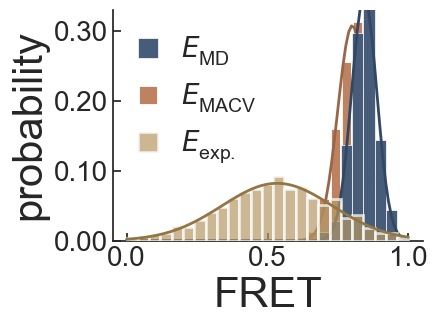

In [21]:
famp.vis_exp_md_acv(experiment_fd, experiment_acv, exp_data, f"{analysis_dir}/Images/Exp_Data", np.mean(fret_traj.mean_E_DA),show_exp=True, show_acv=True, show_md=True)

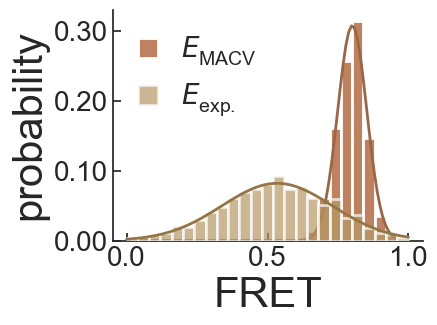

In [22]:
famp.vis_exp_md_acv(experiment_fd, experiment_acv, exp_data, f"{analysis_dir}/Images/Exp_Data", np.mean(fret_traj.mean_E_DA),show_exp=True, show_acv=True, show_md=False)

0.7166962050994901


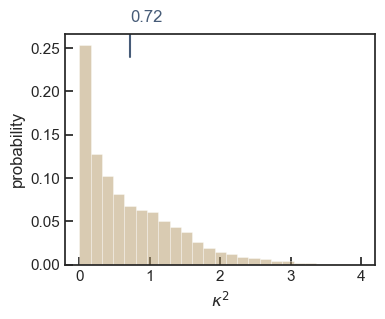

In [23]:
famp.vis_kappa_md(r_kappa_df[2],"kappa2_hist",yp=0.28)

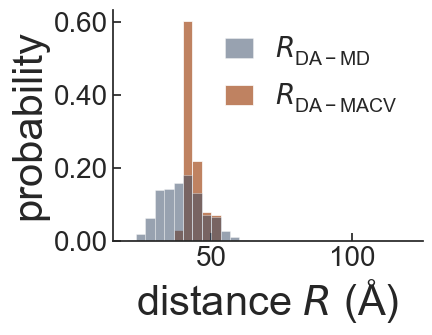

In [24]:
famp.vis_rda_acv_md(fret_traj.mean_R_DA,r_kappa_df[1]*10,f"{analysis_dir}/Images/RDA_MACV_MD",[20,120])

⟨E_MD⟩= 0.84 ± 0.05
⟨E_MACV⟩= 0.79 ± 0.05
⟨E_Exp⟩= 0.53 ± 0.19
⟨E_MACV_no_sn⟩= 0.73 ± 0.06
⟨E_ACV_start⟩= 0.7
⟨E_RDA_MD⟩= 39.709999084472656 ± 7.199999809265137
⟨E_RDA_MACV⟩= 43.58 ± 2.96
⟨E_MD⟩= 0.84 ± 0.05


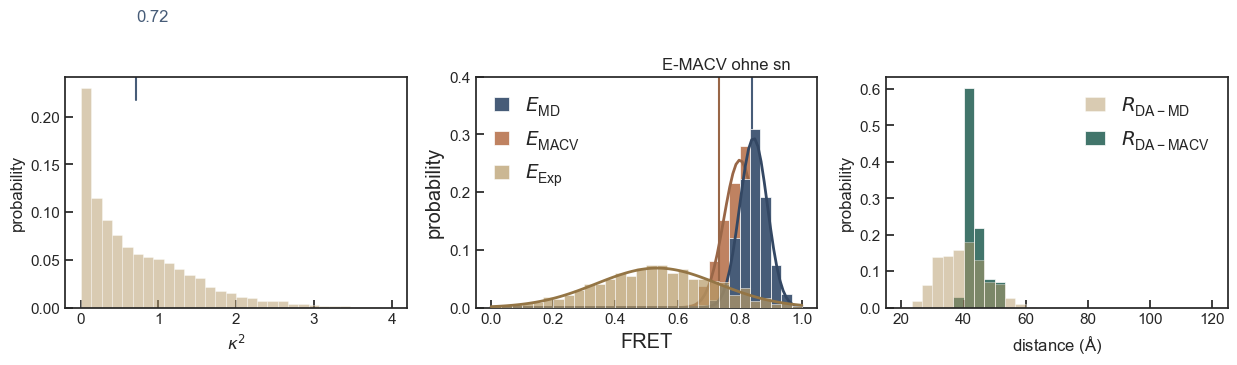

In [25]:
famp.vis_overview(experiment_fd, experiment_acv, exp_data, fret_traj.mean_E_DA, r_kappa_df[2], fret_traj.mean_R_DA,r_kappa_df[1]*10, f"{analysis_dir}/Images/Overview_Powerpoint", yp = 0.30)

### R_DA der expliziten Farbstoffen

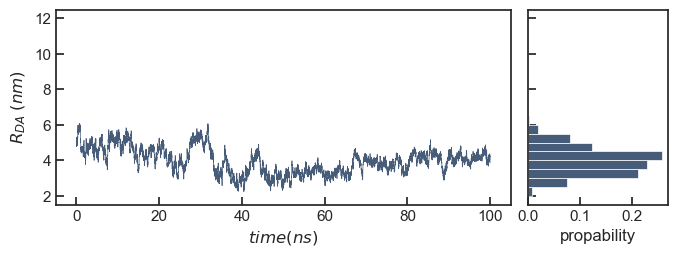

In [26]:
famp.vis_plot_hist(r_kappa_df[0]/1000, r_kappa_df[1], r"$R_{DA}\;(nm)$", f"{analysis_dir}/Images/RDA_MD",famp.c_c(72, 92, 120),[2,12])

### Kappa^2 verteilung berechnet aus den expliziten Farbstoffen

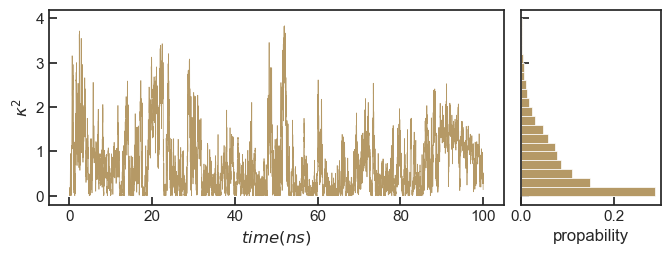

In [27]:
famp.vis_plot_hist(r_kappa_df[0]/1000, r_kappa_df[2],r"$\kappa^{2}$",f"{analysis_dir}/Images/kappa2",famp.c_c(182, 152, 102 ),[0,4])

### R_DA berechnet aus dem MACV

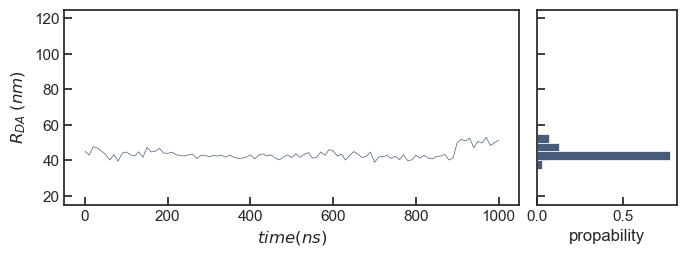

In [28]:
famp.vis_plot_hist(np.arange(0,101,1)*10,fret_traj.mean_R_DA,r"$R_{DA}\;(nm)$",f"{analysis_dir}/Images/RDA_MACV",famp.c_c(72, 92, 120),[20,120])

### Verteilung der Freteffizienzen berechnet aus dem MACV --> ohne shot noise verbreiterung

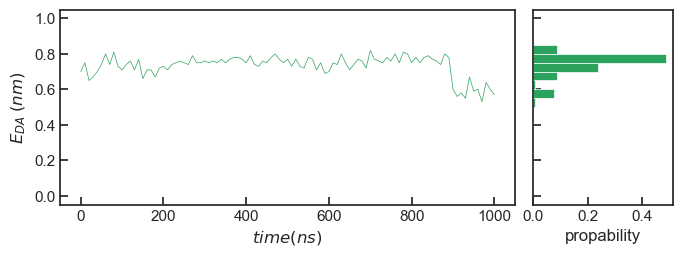

In [29]:
famp.vis_plot_hist(np.arange(0,101,1)*10,fret_traj.mean_E_DA,r"$E_{DA}\;(nm)$", f"{analysis_dir}/Images/E_MACV_no_sn",famp.c_c(44,162,95),[0,1])

### Verteilung der Attechmentpointdistanzen aus der MD

In [30]:
ap_donor_mda = famp.get_atoms_coordinates("2164", u)
ap_acceptor_mda = famp.get_atoms_coordinates("364", u)

ap_distances_mda = famp.calculate_inter_dye_distance(ap_donor_mda,ap_acceptor_mda)

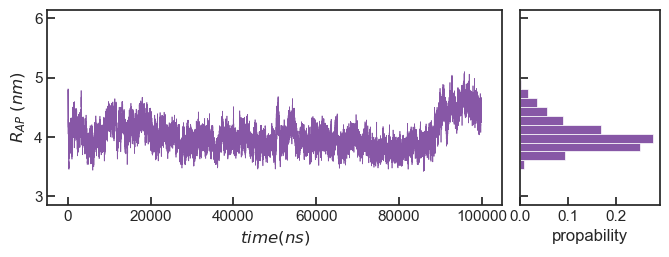

In [31]:
famp.vis_plot_hist(np.arange(0,len(ap_distances_mda),1), ap_distances_mda,r"$R_{AP}\;(nm)$",f"{analysis_dir}/Images/R_AP_MD",famp.c_c(136,86,167),[3,6])

### Verteilung der Attechmentpointdistanzen aus dem MACV

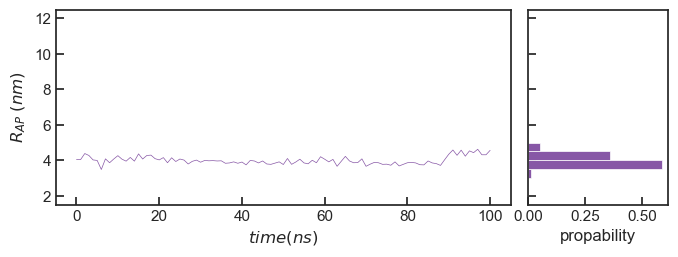

In [32]:
famp.vis_plot_hist(np.arange(0,101,1), fret_traj.R_attach/10,r"$R_{AP}\;(nm)$", f"{analysis_dir}/Images/R_AP_MACV",famp.c_c(136,86,167),[2,12])

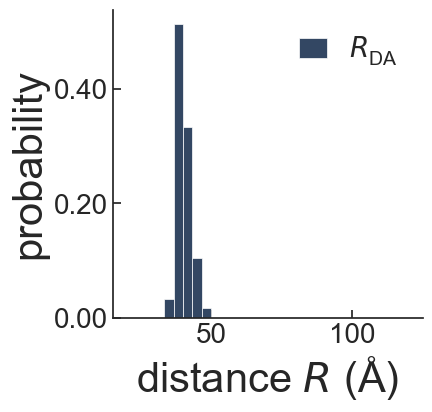

In [33]:
famp.vis_ap_md(ap_distances_mda*10, f"{analysis_dir}/Images/AP_Distanzes_poster", [20,120])

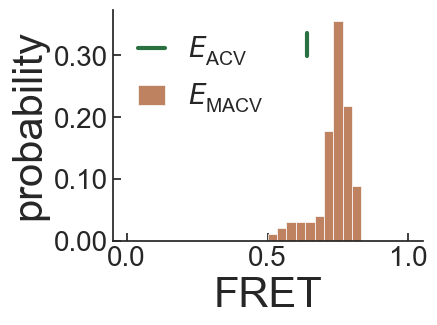

In [34]:
famp.vis_macv_nsn_md(fret_traj,0.64,f"{analysis_dir}/Images/MACV_ACV",[0,1])